In [1]:
import pandas as pd 
import numpy as np 
import os 
import tensorflow as tf 
import tensorflow_addons as tfa
from tensorflow import keras 
import matplotlib.pyplot as plt
import cv2 
from glob import glob

In [2]:
base_models_path = 'C:/Users/user/Desktop/models/child_skin_classification_infection'

In [3]:
df = pd.read_csv(os.path.join(base_models_path, '20220623-044732_efficientb4_effection_history.csv'), sep=',')

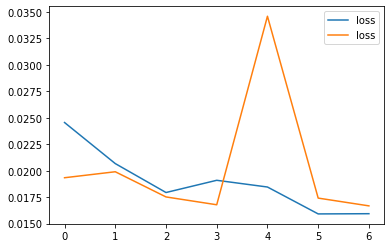

In [5]:
# df
plt.plot(df['loss'], label='loss')
# plt.plot(df['accuracy'], label='loss')
plt.plot(df['val_loss'], label='loss')
# plt.plot(df['val_accuracy'], label='loss')
plt.legend() 
plt.show()

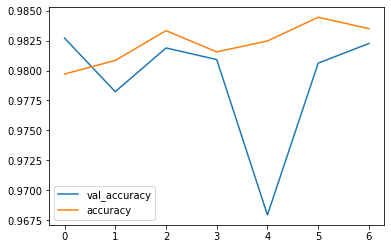

In [6]:
plt.plot(df['val_accuracy'], label='val_accuracy')
plt.plot(df['accuracy'], label='accuracy')
plt.legend()
plt.show() 

In [20]:
model = keras.models.load_model(os.path.join(base_models_path, '20220623-044731_efficientb4_effection.h5'), custom_objects={'focal_loss_fixed' : tfa.losses.SigmoidFocalCrossEntropy()})

In [21]:
effection = ['Abscess',
             'Cellulitis',
             'Chicken pox (varicella)',
             'Cutaneous larva migrans',
             'Eczema herpeticum',
             'Folliculitis',
             'Furuncle',
             'Green nail syndrome',
             'Herpes simplex infection',
             'Herpes zoster',
             'Impetigo',
             'Molluscum contagiosum',
             'Paronychia',
             'Staphylococcal scalded skin syndrome',
             'Tinea capitis',
             'Tinea corporis',
             'Tinea cruris',
             'Tinea faciale', 
             'Tinea manus',
             'Tinea pedis',
             'Verruca plana',
             'Viral exanthem',
             'Wart']


In [9]:
PATH = 'C:/Users/user/Desktop/Child Skin Disease'
# PATH = '/data/snuh/datasets/Child Skin Disease'
# PATH = '../../datasets/Child Skin Disease'
dataset = os.path.join(PATH, 'Total_Dataset')

In [10]:
imgs = [] 
for i in range(7, 9):
    # for key in train_dict.keys():
    img = glob(dataset + f'/H{str(i)}/*/*.jpg')
    imgs.extend(img) 

In [11]:
N_BEF_RES = 256

# def test_skin_data(files):

test_images = [] 
test_labels = [] 

for f in imgs:

    # f = file.decode('utf-8')
    
    img = cv2.imread(f, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    
    # print(f)
    idx = f.split('\\')[-2]
    print(idx) 
    
    key = 0 
    if idx in effection:
        key = 1 
         
    lbl = tf.keras.utils.to_categorical(key, 2)
    
    test_images.append(img)
    test_labels.append(lbl) 
    
test_images = np.reshape(test_images, [-1, N_BEF_RES, N_BEF_RES, 3])
test_labels = np.reshape(test_labels, [-1, 2])

        # yield (img, lbl)  

In [15]:
test_images = test_images.astype(np.float64)
test_labels = test_labels.astype(np.float32)

In [16]:
model.evaluate(test_images, test_labels, batch_size=128)

c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\generic_utils.py:923: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: cannot convert float infinity to integer

In [17]:
y_pred = model.predict(test_images)

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [18]:
from sklearn.metrics import roc_curve
import sklearn

In [19]:
f1_score = sklearn.metrics.f1_score(test_labels.argmax(axis=1), y_pred.argmax(axis=1))
precision = sklearn.metrics.precision_score(test_labels.argmax(axis=1), y_pred.argmax(axis=1))
recall = sklearn.metrics.recall_score(test_labels.argmax(axis=1), y_pred.argmax(axis=1))

NameError: name 'y_pred' is not defined

In [29]:
cm = sklearn.metrics.confusion_matrix(test_labels.argmax(axis=1), y_pred.argmax(axis=1))

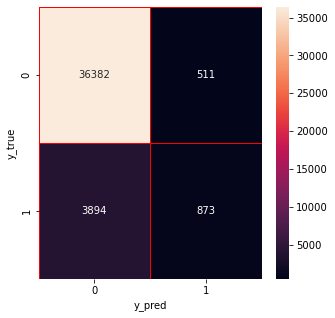

In [30]:
import seaborn as sns

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor='red', fmt='.0f', ax=ax)
plt.xlabel('y_pred')
plt.ylabel('y_true')

plt.show()

In [31]:
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])    
    plt.xlabel('FPR')    
    plt.ylabel('TPR')

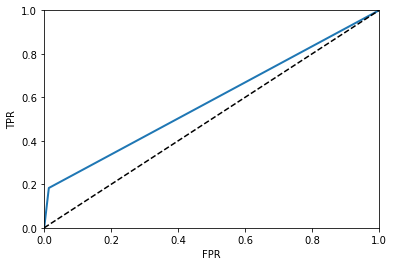

In [33]:
#roc curve 
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_labels.argmax(axis=1), y_pred.argmax(axis=1))
# fpr, tpr, thresholds
plot_roc_curve(fpr, tpr)

In [34]:
from sklearn.metrics import auc 

auc(fpr, tpr)

0.584641590276113